# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
import math
from sklearn.metrics import accuracy_score
import pickle
import copy


# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data from https://www.openml.org/d/554 or from default local location `~/scikit_learn_data/...`
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)
# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
# Rescale grayscale values to [0,1].
X = X / 255.0
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

# print 'data shape: ', X.shape
# print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

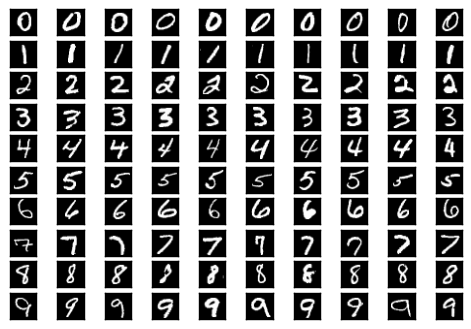

In [3]:
def P1(num_examples=10):

    digits = []

    # Iterate through examples, save the first 10 of each digit
    for d in range(0,num_examples):
        digit_idxs = np.where(mini_train_labels==str(d))[0][0:10]
        for i in digit_idxs:
            digits.append(i)

    fig, ax = plt.subplots(10, num_examples)
    plt.style.use("grayscale")
    plt.setp(ax, xticks=[], yticks=[])

    # Plot each digit
    for idx, digit in enumerate(ax.flat):
        digit.imshow(np.reshape(mini_train_data[digits[idx]], (28,28)))
P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [4]:
from sklearn.metrics import accuracy_score

def P2(k_values):

    knn_classifiers = {}
    k_values = [1, 3, 5, 7, 9]
    accs = []

    for k in k_values:        
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(mini_train_data, mini_train_labels)

        knn_classifiers[k] = knn

        y_pred = knn.predict(dev_data)
        accuracy = accuracy_score(y_pred, dev_labels)
        accs.append(accuracy)
        if k == 1:    
            print(classification_report(y_pred, dev_labels))
    columns = ['Neighbors', 'Accuracy']
    p2_df = pd.DataFrame(columns = columns)
    p2_df['Neighbors'] = k_values
    p2_df['Accuracy'] = accs
    p2_df.set_index('Neighbors', inplace=True)
    print(p2_df)
    
k_values = [1, 3, 5, 7, 9]
P2(k_values)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.98      0.89      0.93       131
           2       0.79      0.90      0.84        93
           3       0.87      0.93      0.90        90
           4       0.85      0.91      0.88        86
           5       0.88      0.86      0.87        90
           6       0.92      0.92      0.92       102
           7       0.94      0.85      0.89       113
           8       0.77      0.83      0.80        87
           9       0.86      0.80      0.83       102

   micro avg       0.88      0.88      0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

           Accuracy
Neighbors          
1             0.884
3             0.876
5             0.882
7             0.877
9             0.875


**ANSWER**: We can see the accuracy of the K nearest neighbor classifiers are fairly similar and slightly decrease as we increase the size of k. We could argue that we are making the model too complex by widening the range of neighbors, which might confuse the model. The F-1 score can be used to measure the model's accuracy, as it considers both the precision and recall of the test. Judging by the f1-score, 8 seems to be the most difficult digit for the k=1 model

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [6]:
def P3(train_sizes, accuracies):
    runtimes = []

    train_data_shape = train_data.shape[0]
    for t in train_sizes:
        if t > train_data_shape:
            continue

        start = time.time()
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(train_data[:t], train_labels[:t])
        y_pred = knn.predict(dev_data)
        accuracy = accuracy_score(y_pred, dev_labels)
        end = time.time()
        runtime = end - start
        accuracies.append(accuracy)
        runtimes.append(runtime)

    columns = ['Train Size', 'Accuracy', 'Runtime(s)']
    df = pd.DataFrame(columns = columns)
    df['Train Size'] = train_sizes
    df['Accuracy'] = accuracies
    df['Runtime(s)'] = runtimes
    df.set_index('Train Size', inplace=True)
    return df
    
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

,Accuracy,Runtime(s)
Train Size,,
100,0.702,0.133704
200,0.791,0.229417
400,0.811,0.457440
800,0.866,0.991214
1600,0.905,2.016176
3200,0.927,4.119903
6400,0.939,8.421886
12800,0.952,17.555655
25000,0.962,38.081707


**ANSWER**: A 6400 sized training set seems to be the best option given its accuracy/runtime tradeoff

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [7]:
def P4(train_sizes_vector, accuracies):
    
    def get_lin_log_accuracies(train_sizes_vector, accuracies, n):
    
        test_n = np.array([[n]])

        # Train default linear regression
        lreg = LinearRegression()
        lreg.fit(train_sizes_vector, accuracies)
        result=lreg.predict(test_n)    

        # Train linear regression with log transformed accuracies
        lreg2 = LinearRegression()
        log_trans = [math.log(a/(1-a)) for a in accuracies]
        lreg2.fit(train_sizes_vector,log_trans)
        result_2 = lreg2.predict(test_n)

        # Log transform predictions
        result_log = math.exp(result_2[0])/(1+math.exp(result_2[0]))

        return result[0], result_log
    
    # Get resulting accuracies with default linear regression and after performing log transform on y
    result_60000, result_60000_log = get_lin_log_accuracies(train_sizes_vector, accuracies, 60000)
    columns = ['Training Size', 'Default Accuracy', 'Accuracy With Log Transform']
    df = pd.DataFrame(index = [0], columns = columns)    
    
    # Experiment with larger values of n
    result_100000, result_100000_log = get_lin_log_accuracies(train_sizes_vector, accuracies, 100000)
    result_1000000, result_1000000_log = get_lin_log_accuracies(train_sizes_vector, accuracies, 1000000)
    
    df.loc[0] = [60000, result_60000, result_60000_log]
    df.loc[1] = [100000, result_100000, result_100000_log]
    df.loc[2] = [1000000, result_1000000, result_1000000_log]
    
    return df

# We reshape the train_sizes to a single column vector so that our Linear Regerssion model can use it as its input
train_sizes_vector = np.reshape(train_sizes, (-1,1))



P4(train_sizes_vector, accuracies)

,Training Size,Default Accuracy,Accuracy With Log Transform
0,60000,1.24469,0.998128
1,100000,1.51821,0.999911
2,1e+06,7.67247,1


<module 'matplotlib.pyplot' from '//anaconda/envs/keras/lib/python3.5/site-packages/matplotlib/pyplot.py'>

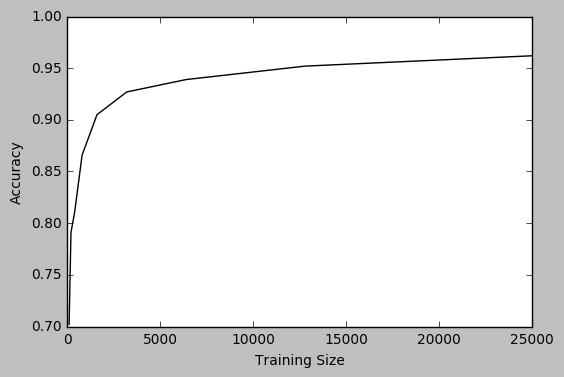

In [8]:
plt.plot(train_sizes,accuracies)
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt

**ANSWER**: The default accuracy (1.244) of the linear regression is obviously incorrect, as it cannot be higher than 1.0. Since we are dealing with a linear regression, we need to transform the prediction variable because our data is non-linear. Our default linear regression does not consider that accuracy, our y, needs to be bound by 1, so it will give values greater than 1. Instead, we need to perform a log transform on the accuracy, which gives us 0.998. I even experimented by running the same test with a larger n (100,000), and the resulting accuracy got even closer to 1.0. When I finally made n = 1,000,000 we could see it reached 1.0, but did not surpass. A log transform is appropriate for this case, since it does not allow the accuracy to surpass 1.


Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

Predicted    0    1   2   3   4   5   6   7   8   9
True                                               
0          101    0   1   0   0   0   1   1   2   0
1            0  116   1   0   0   0   0   0   1   0
2            1    4  84   2   2   0   2   4   6   1
3            0    2   0  84   0   6   0   2   3   0
4            0    0   1   0  78   0   0   2   0  11
5            2    0   0   1   1  77   5   0   2   0
6            1    2   1   0   1   2  94   0   1   0
7            0    1   1   0   0   0   0  96   0   4
8            1    5   4   3   1   3   0   1  72   4
9            0    1   0   0   3   2   0   7   0  82

9 was mistaken for a 4 a total of 11 times.



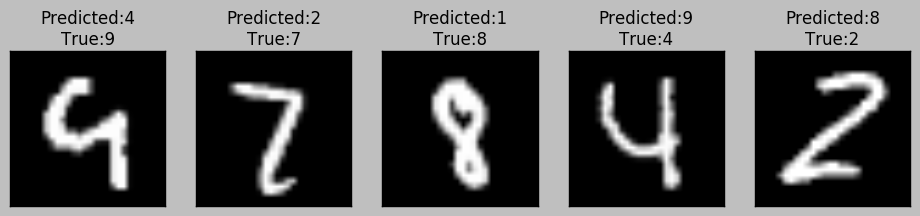

In [9]:
def P5():
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(mini_train_data, mini_train_labels)
    y_pred = knn.predict(dev_data)    

    pd_cmatrix = pd.crosstab(dev_labels, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
    
    # Iterate through matrix, find most frequent confusion
    pd_cmatrix = pd_cmatrix.drop(columns=['All'])
    pd_cmatrix = pd_cmatrix.drop('All')
    pd_cmatrix.columns = pd.to_numeric(pd_cmatrix.columns)

    print(pd_cmatrix)

    
    # Set -1 when True and Predicted index are the same (correct predictions), then find idxmax to get most mistaken
    big_mistakes = [0] * 10
    most_mistaken = (-1,-1)
    max_mistake = -1

    for i in range(10):
        pd_cmatrix[i][i] = -1
        max_idx = int(pd_cmatrix[i].idxmax())    
        if max_idx >= max_mistake:
            most_mistaken = (max_idx, i)
            max_mistake = pd_cmatrix[max_idx][i]
            
    
    # Plot some of the mistakes
    prediction_matched = y_pred==dev_labels
    sample_mistakes = [index for index, x in enumerate(prediction_matched) if x==False][0:5]
    
    fig, ax = plt.subplots(1, 5)
    fig.subplots_adjust(left = 3, right = 4.5)
    plt.style.use("grayscale")
    plt.setp(ax, xticks=[], yticks=[])
    for idx, mistake in enumerate(ax.flat):
        mistake.set_title('Predicted:' + str(y_pred[sample_mistakes[idx]]) + '\n' + 'True:' + str(dev_labels[sample_mistakes[idx]]))
        mistake.imshow(np.reshape(dev_data[sample_mistakes[idx]], (28,28)))

    print("")
    print(str(most_mistaken[0]) + " was mistaken for a " + str(most_mistaken[1])  
          + " a total of " + str(max_mistake) + " times.")
    print("")
        
    
P5()





**Answer**: The confusion matrix shows that 9 was mistaken for 4 a total of 11 times. Above, we have displayed a number of mistaken digits. We can see how 9 and 4 can be easily misconstrued, as they do look similar if the top of the 9 is not connected completely. Similarly, 7 and 2 can also look the same if the writer does not strike through the middle of the 7.

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [10]:
def P6():
    
    # Brief: Blur data by taking average of surrounding pixel for each pixel
    def blur(data_to_transform):
        
        # Reshape image to 2D
        reshaped=[np.reshape(data, (28,28)) for data in data_to_transform]
        blurred_data_set = []

        # Iterate through each row/column for each digit image and blur
        for data in range(len(reshaped)):
            blurred = [[0 for x in range(28)] for y in range(28)]
            for col in range(28):
                for row in range(28):

                    # Top left corner
                    if not col and not row:
                        blurred[row][col] = (reshaped[data][row][col] + reshaped[data][row + 1][col] + reshaped[data][row + 1][col + 1]
                                              + reshaped[data][row][col+1]) / 4

                    # Bottom right corner
                    elif col is 27 and row is 27:
                        blurred[row][col]=(reshaped[data][row][col]+reshaped[data][row-1][col-1]
                                    +reshaped[data][row-1][col]+reshaped[data][row][col-1])/4

                    # Rightmost column
                    elif col is 27:
                        if row:
                            blurred[row][col] = (reshaped[data][row][col] + reshaped[data][row-1][col] + reshaped[data][row-1][col-1]
                                                + reshaped[data][row+1][col] + reshaped[data][row+1][col-1]
                                                 + reshaped[data][row][col-1]) / 6
                        else:
                            blurred[row][col] = (reshaped[data][row][col] + reshaped[data][row + 1][col] +
                                                 reshaped[data][row][col - 1]
                                                 + reshaped[data][row - 1][col - 1]) / 4

                    # Bottom row
                    elif row is 27:
                        if col:
                            blurred[row][col] = (reshaped[data][row][col] + reshaped[data][row][col-1] + reshaped[data][row][col+1]
                                        + reshaped[data][row-1][col-1] + reshaped[data][row-1][col]
                                         + reshaped[data][row-1][col+1]) / 6
                        else:
                            blurred[row][col] = (reshaped[data][row][col] + reshaped[data][row][col - 1] +
                                                 reshaped[data][row][col - 1]
                                                 + reshaped[data][row - 1][col + 1]) / 4

                    # Leftmost column
                    elif not col:
                        blurred[row][col]=(reshaped[data][row][col]+reshaped[data][row+1][col+1]
                                       + reshaped[data][row - 1][col] + reshaped[data][row][col + 1]
                                        +reshaped[data][row-1][col+1]+reshaped[data][row+1][col])/6
                    # Top row
                    elif not row:
                        blurred[row][col]=(reshaped[data][row][col]+reshaped[data][row+1][col+1]
                                       + reshaped[data][row][col + 1] + reshaped[data][row][col - 1]
                                        +reshaped[data][row+1][col-1]+reshaped[data][row+1][col])/6

                    else:
                        blurred[row][col] = (reshaped[data][row][col] + reshaped[data][row-1][col-1] + reshaped[data][row][col-1]
                                                                    + reshaped[data][row+1][col-1] + reshaped[data][row][col+ 1]
                                                                    + reshaped[data][row + 1][col+1] + reshaped[data][row+1][col]
                                                                    + reshaped[data][row + 1][col-1] + reshaped[data][row][col - 1])  / 9
            blurred_data_set.append(blurred)
        return blurred_data_set

    
    # brief: Train 1-NN, return accuracy
    def run_knn(train, test, k):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(train, mini_train_labels)
        y_pred = knn.predict(test)
        acc = accuracy_score(y_pred, dev_labels)        
        return acc

    # Blur and reshape mini_train_data and dev_data for training/testing
    blurred_mini = blur(mini_train_data)
    blurred_mini = np.reshape(blurred_mini, (len(mini_train_labels), -1))
    blurred_dev = blur(dev_data)
    blurred_dev = np.reshape(blurred_dev, (len(dev_labels), -1))

    
    df = pd.DataFrame(columns=['Augmentation', 'Accuracy, K=1', 'Accuracy, K=3', 'Accuracy, K=6'])
    df.loc[0] = ['None', run_knn(mini_train_data, dev_data, 1), run_knn(mini_train_data, dev_data, 3), run_knn(mini_train_data, dev_data, 6)]
    df.loc[1] = ['Blurred Training Data', run_knn(blurred_mini, dev_data, 1), run_knn(blurred_mini, dev_data, 3), run_knn(blurred_mini, dev_data, 6)]
    df.loc[2] = ['Blurred Dev Data', run_knn(mini_train_data, blurred_dev,1),run_knn(mini_train_data, blurred_dev, 3), run_knn(mini_train_data, blurred_dev, 6)]
    df.loc[3] = ['Blurred Both', run_knn(blurred_mini, blurred_dev,1), run_knn(blurred_mini, blurred_dev,3), run_knn(blurred_mini, blurred_dev,6)]    

    return df


P6()


,Augmentation,"Accuracy, K=1","Accuracy, K=3","Accuracy, K=6"
0,None,0.884,0.876,0.884
1,Blurred Training Data,0.894,0.892,0.891
2,Blurred Dev Data,0.874,0.863,0.868
3,Blurred Both,0.903,0.900,0.899


**ANSWER**: When training an image recognition model, it is a common practice to preprocess data and apply some image augmentation techniques to account for bias. Methods such as playing with brightness, flipping images, and shifting images, and blurring them help models generalize and account for variations of the image that may not have been captured in the default training data. The results suggest that blurring both the training and testing data actually gives us better results than the natural digits. Blurring an image helps the model pay learn an "attention map", as augmenting a pixel using its pixels around it augments its influence, helping the model learn desirable pixels. To achieve the best results, any preprocessing done to your training data must also be done to your testing data. Thus, bluring both the mini and dev data achieves the highest accuracy.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [11]:
def P7():

    # brief: Convert a pixels to 0, 1, or 2 if they fall in the ranges of white, gray, or black
    def convert_multi(orig_data):
        ret_multi = []
        for index, data in enumerate(orig_data):
            new_point = []
            for pixel in data:
                if 0 <= pixel < .1:
                    new_point.append(0.0)
                elif .1 <= pixel <= .3:
                    new_point.append(1.0)
                else:
                    new_point.append(2.0)
            ret_multi.append(new_point)

        return ret_multi
    
    bnb = BernoulliNB(binarize = 0.1)
    bnb.fit(mini_train_data, mini_train_labels)    
    y_pred = bnb.predict(dev_data)
    acc = accuracy_score(y_pred, dev_labels)    
    
    mnb = MultinomialNB()    
    multi_train_data = convert_multi(mini_train_data)
    mnb.fit(multi_train_data, mini_train_labels)    
    y_pred2 = mnb.predict(convert_multi(dev_data))
    acc2 = accuracy_score(y_pred2, dev_labels)
    
    df = pd.DataFrame(columns = ['Model', 'Accuracy'])
    df.loc[0] = ['Bernoulli', acc]
    df.loc[1] =  ['Mutlinomial', acc2]
    #df.set_index('Model', inplace=True)    
    
    return df    

P7()

,Model,Accuracy
0,Bernoulli,0.814
1,Mutlinomial,0.811


**ANSWER**: The bernoulli naive bayes classifier actually produces better results than the Multinomial with my current setup. For the Bernoulli Classifier, I set binarize to 0.1, meaning that any value less than 0.1 would be considered 0, while anything greater would be 0.1. Meanwhile, for multinomial, I converted anything between 0 and 0.1 to 0 (black), everything between .1 to .3 to 1.0 , and every pixel above .3 to 2.0. The results did not improve. One reason that the Multinomial Classifier did not behave as well could be that the ranges I set in my `convert_multi` were a bit too conservative. Another reason could be that by adding a new feature, we have increased the bias of our model. With the Bernoulli Classifier, it had only 2 features to choose from: whether the pixel was a 0.0 or a 1.0. Now, by introducing a 2.0 into the feature space, we have made our model slightly more complex, and in turn may have introduced a level of bias that is actually hurting our model's accuracy when it tries to make a prediction on a test set it has not seen before.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [6]:
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
import warnings


cv = LeaveOneGroupOut()

def P8(alphas):
    
    # Avoid warnings during gridsearch
    warnings.filterwarnings("ignore")
    
    gsearch = GridSearchCV(BernoulliNB(binarize = 0.1), alphas,)
    gsearch.fit(mini_train_data, mini_train_labels)    
    print ("Best Alpha = " + str(gsearch.best_params_['alpha']))
    
    bnb_alpha_0 = BernoulliNB(binarize = 0.1, alpha = 0)
    bnb_alpha_0.fit(mini_train_data, mini_train_labels)    
    y_pred_2 = bnb_alpha_0.predict(dev_data)
    acc2 = accuracy_score(y_pred_2, dev_labels)
    print ("Accuracy when alpha is 0 (not using GridSearch) = " + str(acc2))
    
    gsearch_readable = pd.DataFrame.from_dict(gsearch.cv_results_)

    columns = []
    df_8 = pd.DataFrame(columns = columns)
    df_8['Alpha'] = alphas['alpha']
    df_8['Accuracy'] = gsearch_readable['mean_test_score']
    
    # Resume warnings
    warnings.resetwarnings()
    return df_8


alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
P8(alphas)

Best Alpha = 0.0001
Accuracy when alpha is 0 (not using GridSearch) = 0.813


,Alpha,Accuracy
0,0.0000,0.810
1,0.0001,0.822
2,0.0010,0.822
3,0.0100,0.820
4,0.1000,0.820
5,0.5000,0.819
6,1.0000,0.810
7,2.0000,0.807
8,10.0000,0.771


**ANSWER**: The best Alpha value was 0.0001, which produced an accuracy of 0.822. When alpha is 0, we see an accuracy of .810. We expect this to be lower, as we will be doing no smoothing will not be well fit to test on our testing data. I double checked this by training a classifier with alpha = 0, as GridSearchCV will give different results because it partitions the training data. Nevertheless, I saw an accuray of .813, very close to what we saw with GridSearch. I chose to hide warnings that were being printed for the alpha being doing small because they made it difficult to see the printed results.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def P9():

    gnb = GaussianNB()
    gnb.fit(mini_train_data, mini_train_labels)
    y_pred = gnb.predict(dev_data)
    
    bnb = BernoulliNB(binarize = 0.1)
    bnb.fit(mini_train_data, mini_train_labels)
    y_pred2 = bnb.predict(dev_data)
    
    gnb2 = make_pipeline(StandardScaler(), PCA(n_components=30), GaussianNB())
    gnb2.fit(mini_train_data, mini_train_labels)
    y_pred3 = gnb2.predict(dev_data)
    acc3 = accuracy_score(y_pred3, dev_labels)

    columns = ['Model','Accuracy']
    p9_df = pd.DataFrame(columns = columns)
    p9_df.loc[0] = ['Standard GaussianNB Accuracy', str(accuracy_score(y_pred, dev_labels))]
    p9_df.loc[1] = ['Standard BernoulliNB Accuracy', str(accuracy_score(y_pred2, dev_labels))]
    p9_df.loc[2] = ['Modified GaussianNB Accuracy', str(accuracy_score(y_pred3, dev_labels))]
    
    return p9_df
P9() 

,Model,Accuracy
0,Standard GaussianNB Accuracy,0.593
1,Standard BernoulliNB Accuracy,0.814
2,Modified GaussianNB Accuracy,0.755


**ANSWER**: By standardizing the data and applying Principal Component Analysis (PCA), we are able to increase the accuracy of the Guassian Naive Bayes classifier. Applying PCA helps reduce the dimmensionality and performs feature extraction, while StandardScaler() helps normalize the data for the Gaussian Naive Bayes classifier to process. These steps help raise the accuracy of the classifier

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

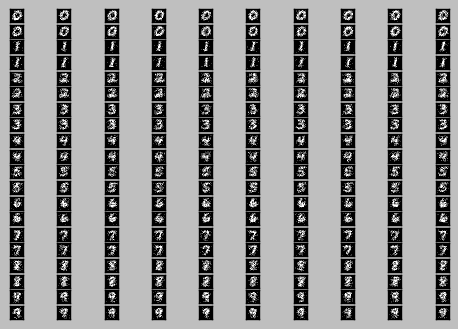

In [13]:
def P10(num_examples):

    # Randomly choose if using the probability or its inverse (p or p-1)
    def choose_rand(binary_list, probs):
        x = random.uniform(0, 1)
        total = 0.0
        for ret, prob in zip(binary_list, probs):
            total += prob
            if x < total: 
                break
        return ret

    
    bnb = BernoulliNB(binarize = 0.1)
    bnb.fit(mini_train_data, mini_train_labels)    
    prob_vector = np.exp(bnb.feature_log_prob_)
    
    gen_digits = []
    
    # Iterate through probability vector, for each probability and its inverse, randomly return 0 or 1
    for prob in prob_vector:
        for i in range(20):
            digit_array = []
            for p in prob:
                digit_array.append(choose_rand([1,0], [p, 1-p]))
            gen_digits.append(digit_array)

            
    fig, ax = plt.subplots(20, 10)
    plt.style.use("grayscale")
    plt.setp(ax, xticks=[], yticks=[])
    for index, digit in enumerate(ax.flat):
        digit.imshow(np.reshape(gen_digits[index], (28,28)))

P10(20)

**ANSWER**: The generated digits look like scribbled, blurrier versions of the original digits. This makes sense, since these are digits generated based on random chance to be either zero or one for each pixel. Where we would have seen a black pixel in the original image, we might see a white pixel in the generated image, based on random chance.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [52]:
def P11(buckets, correct, total):

    def get_bucket(p):
        for i in range(len(buckets)):                
            # Return 0 if p is less than the smallest bucket (0.5)
            if not i and p < buckets[i]:
                    return i
            # Return 1 if prob is >= largest prob in bucket (1.0)
            elif i is len(buckets) - 1 and p >= buckets[i]:
                return i
            # If prob is somewhere between buckets[i] and buckets[i-1], return i
            elif p >= buckets[i-1] and p < buckets[i]:
                return i
        return i      
    
    bnb=BernoulliNB(binarize=.08, alpha = 0.1)
    bnb.fit(mini_train_data, mini_train_labels)
    y_pred = bnb.predict(dev_data)
    acc = accuracy_score(y_pred, dev_labels)    
    
    # Get the probabilities. This should be a 1000 by 10 vector, with label probabilities for each data point
    predict_probs = bnb.predict_proba(dev_data)
    y_pred = bnb.predict(dev_data)
    
    # Iterate through probabilities for each point. Get its respective bucket and if point was correctly predicted, 
    # increment correct for that bucket
    for i, prob_row in enumerate(predict_probs):
        bucket = get_bucket(np.amax(prob_row))
        total[bucket] += 1
        if y_pred[i] == dev_labels[i]:
            correct[bucket] += 1    
    
buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

P11_accuracies = []
columns = ['Prediction <=', 'Total', 'Accuracy']
p11_df = pd.DataFrame(columns = columns)

for idx, i in enumerate(range(len(buckets))):
   accuracy = 0.0   
   if (total[i] > 0): 
     accuracy = float(correct[i]) / float(total[i])   
   p11_df.loc[idx] = [str(buckets[i]), total[i], accuracy]

p11_df

,Prediction <=,Total,Accuracy
0,0.5,0,0.000000
1,0.9,32,0.375000
2,0.999,64,0.312500
3,0.99999,68,0.661765
4,0.9999999,57,0.526316
5,0.999999999,47,0.787234
6,0.99999999999,56,0.839286
7,1.0,52,0.788462
8,1.0,624,0.945513


**ANSWER**: We do see a positive trend with accuracy as the probability increases, as we have reached .9455 when Prediction is at 1.0. That being said, we should not be hasty and classify this as a strong calibrated classifier, as we can observe that at 0.999, our accuracy is at .31, and at 0.9 posterior probability, our accuracy is still only at 0.375. The accuracies are not consistently increasing and do have dips, although they are moving in a positive direction as the predicitons bucket increases. I would classify this as a slightly weakly calibrated classifier.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [3]:
def P12():
    
    #brief: Converts pixel if it is in "blank space" from 0 to 1
    def convert_pixels(digit, x, y, old_pixel, new_pixel):
        # Return if current data point is not the old value
        if digit[x][y] != old_pixel:
            # If the current x, y character is not the old_pixel, then do nothing.
            return

        # Change the pixel at world[x][y] to new_pixel
        digit[x][y] = new_pixel

        # Check up, down, left, right of the pixel        
        # up
        if y > 0: 
            convert_pixels(digit, x, y-1, old_pixel, new_pixel)
        # left
        if x > 0:
            convert_pixels(digit, x-1, y, old_pixel, new_pixel)

        # right
        if x < len(digit) -1: 
            convert_pixels(digit, x+1, y, old_pixel, new_pixel)

        # down
        if y < len(digit[0]) -1: 
            convert_pixels(digit, x, y+1, old_pixel, new_pixel)


    # brief: returns the number of enclosed regions
    def get_encolsing_regions(digit):
        regions = -1
        for x in range(len(digit)):
            for y in range(len(digit[0])):
                if not digit[x][y]:
                    convert_pixels(digit, x, y, 0, 1)
                    regions += 1
        return regions
        
    # brief: Returns data point with added extra features
    def extra_features(data_point, n):
        reshaped = np.reshape(data_point,(28,28))
        rowSum = reshaped.sum(axis=1)
        colSum = reshaped.sum(axis=0)
        
        enclosing_regions = get_encolsing_regions(copy.deepcopy(reshaped))
        
        if n == 1:
            data_point = np.append(data_point,rowSum)
            data_point = np.append(data_point,colSum)
        
        elif n == 2:
            data_point = np.append(data_point, enclosing_regions)
        
        else:
            data_point = np.append(data_point,rowSum)
            data_point = np.append(data_point,colSum)
            data_point = np.append(data_point, enclosing_regions)            
        
        return data_point

    
    # First train a Naive Bayes classsifier and test with the dev_data
    bnb = BernoulliNB(binarize = 0.1)
    bnb.fit(mini_train_data, mini_train_labels)    
    y_pred = bnb.predict(dev_data)
    acc = accuracy_score(y_pred, dev_labels)
    
    
    # Augment the training data by adding the summed rows and columns to the feature set
    new_mini_train = np.array([extra_features(data_point, 1) for data_point in mini_train_data])
    new_dev_data = np.array([extra_features(data_point, 1) for data_point in dev_data])
    
    
    # Train a new classifier with the augmented data
    bnb2 = BernoulliNB(binarize = 0.1)
    bnb2.fit(new_mini_train, mini_train_labels)
    y_pred2 = bnb2.predict(new_dev_data)
    acc2 = accuracy_score(y_pred2, dev_labels)
    
    
    # Get a new set of features data with enclosed regions
    new_mini_train2 = np.array([extra_features(data_point, 2) for data_point in mini_train_data])
    new_dev_data2 = np.array([extra_features(data_point, 2) for data_point in dev_data])
    
    
    # Train a new classifier with enclosed regions feature added
    bnb3 = BernoulliNB(binarize = 0.1)
    bnb3.fit(new_mini_train2, mini_train_labels)
    y_pred3 = bnb3.predict(new_dev_data2)
    acc3 = accuracy_score(y_pred3, dev_labels)        
    
    # Now get a new set of augmented training data with the rows/columsn summed and add enclosed regions
    new_mini_train3 = np.array([extra_features(data_point, 3) for data_point in mini_train_data])
    new_dev_data3 = np.array([extra_features(data_point, 3) for data_point in dev_data])
    
    # Train a new classifier with row/columns sums and enclosed regions
    bnb4 = BernoulliNB(binarize = 0.1)
    bnb4.fit(new_mini_train3, mini_train_labels)
    y_pred4 = bnb4.predict(new_dev_data3)
    acc4 = accuracy_score(y_pred4, dev_labels)
    
    
    columns = ['Add Features', 'Accuracy']
    p12_df = pd.DataFrame(columns = columns)
    p12_df['Add Features'] = ['None', 'Row/Col Sum', 'Enclosed Regions', 'Row/Col Sum + Enclosed Regions']
    p12_df['Accuracy'] = [acc, acc2, acc3, acc4]
    #p12_df.set_index('Add Features', inplace=True)
    
    
    return p12_df
    

P12()

,Add Features,Accuracy
0,None,0.814
1,Row/Col Sum,0.811
2,Enclosed Regions,0.824
3,Row/Col Sum + Enclosed Regions,0.817


**Answer**: I trained 4 classifiers - One with no added features, one with the added row/column sum features, one with the added enclosed regions, and one with the row/column sums **and** enclosed regions. Surprisingly, the row/column sums actually degraded the accuracy, while the enclosed regions improved the accuracy. It seems that using the row/column sums might actually be confusing our model, because many digits might have rows and columns with the exact same summed values. For example, a 7, 9, and 4 each might show the same sum for columns if the individual who wrote them uses a straight line as the tail for all 3 digits in the same general area when handwriting the digit. On the other hand, an enclosed region intuitively seems more robust. No matter an individual's penmenship, he/she will  generally make an effort to make those fully enclosed circles when writing digits such as 8, 9, or 0. This feature proves to be more useful in predicting, and we can see how an enclosed feature has more of a chance of being consistent from individual to individual when writing digits